<a href="https://colab.research.google.com/github/Windtwist/nlp-proj/blob/main/Caption_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') #mount google drive

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf

In [ ]:
# @title Import necessary pakages
import string
import numpy as np
import pandas as pd
from numpy import array
from PIL import Image
import pickle

import matplotlib.pyplot as plt
import keras
import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import tensorflow as tf
from tqdm import tqdm

from nltk.translate.bleu_score import sentence_bleu #bleu score

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [ ]:
# @title Dataset download
import zipfile

dataset_path = '/content/gdrive/MyDrive/flickr8k/archive (2).zip'

extraction_path = '/content/flickr8k'

# Make sure the extraction directory exists
os.makedirs(extraction_path, exist_ok=True)

# Extract the dataset
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print("Extraction completed.")


Extraction completed.


List images to check if import was sucesfull

In [ ]:
image_path = "/content/flickr8k/Images"
dir_Flickr_text = "/content/flickr8k/captions.txt"

jpgs = os.listdir(image_path)
print("Total Images in Dataset = {}".format(len(jpgs)))

Total Images in Dataset = 8091


format data into dataframe - index|image|caption

In [ ]:
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
   col = line.split(',')
   if len(col) < 2:  #one comma separating two items
        continue
   image_id = col[0].strip()  #image file name
   caption = col[1].strip().lower()  #caption all lowercase - strip spaces
   datatxt.append([image_id, caption])

data = pd.DataFrame(datatxt, columns=["image", "caption"])

data = data.drop(data.index[0])

data = data.reset_index(drop=True)
data.insert(0, 'index', range(0, len(data)))

data = data.reindex(columns =['index','image','caption'])

uni_filenames = np.unique(data.image.values)

data.head()



,index,image,caption
0,0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,1,1000268201_693b08cb0e.jpg,a girl going into a wooden building .
2,2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .
3,3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...


Show images and responding captions (ground truths) based on the created dataframe

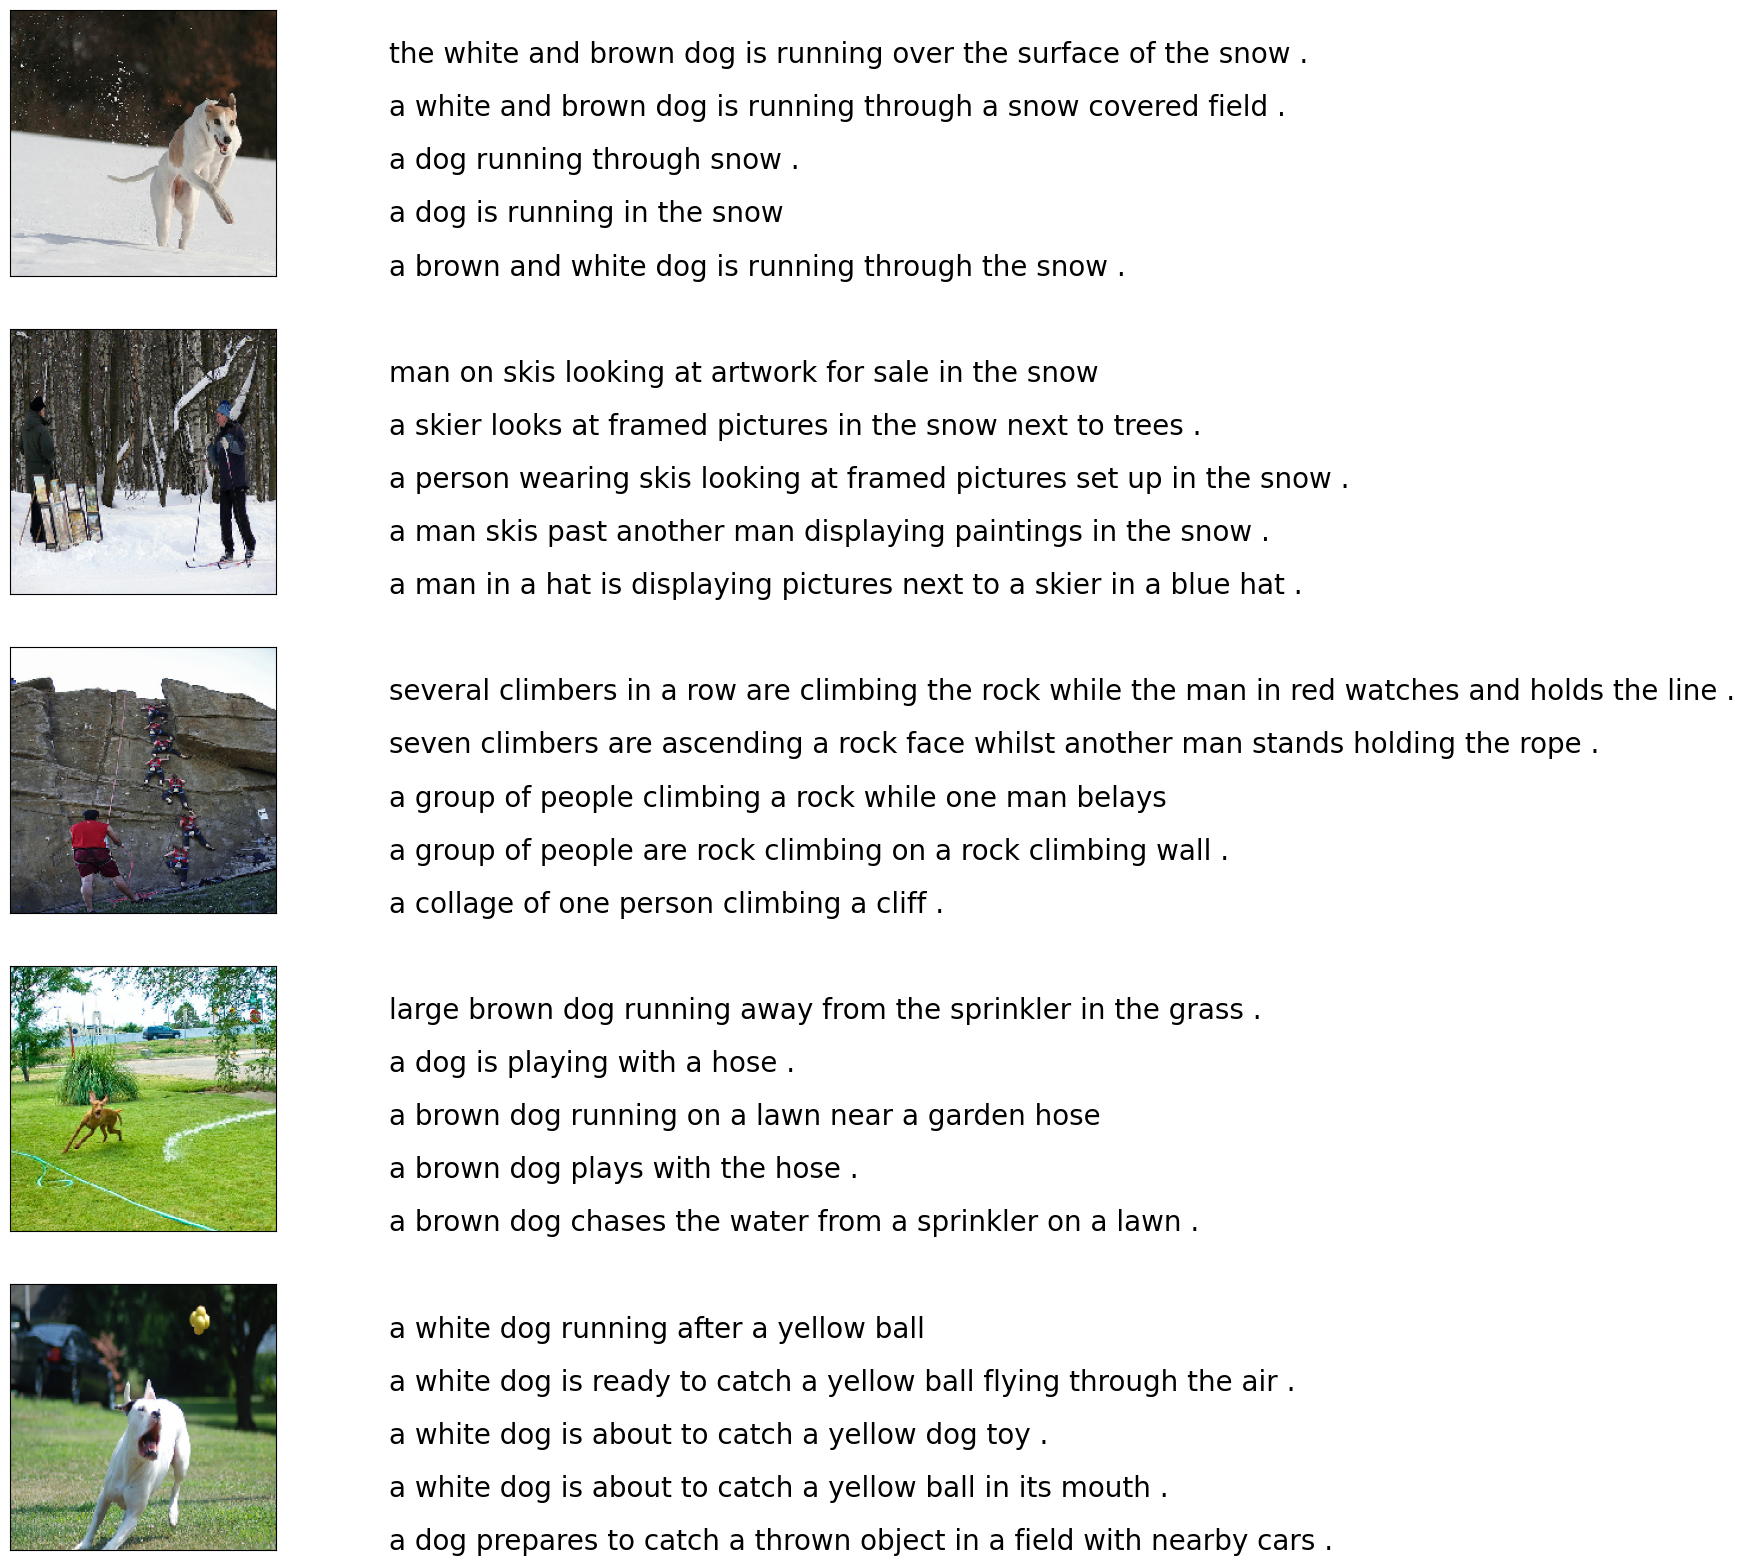

In [ ]:
from keras.preprocessing.image import load_img, img_to_array

npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:15]:
    filename = image_path + '/' + jpgfnm
    captions = list(data["caption"].loc[data["image"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)

    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

In [ ]:
vocabulary = []
for txt in data.caption.values:
    vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 8871


In [ ]:
img = data["image"].tolist()
caption = data["caption"].tolist()

In [ ]:
print(f"len(img) : {len(img)}")
print(f"len(caption) : {len(caption)}")

len(img) : 40455
len(caption) : 40455


Clean the data methods

In [ ]:
#remove punctuations
def remove_punc(text):
    no_punc = text.translate(string.punctuation)
    return(no_punc)

#remove single characters - text that has length  less than 1
def filter_text(text):
    filtered = ""
    for word in text.split():
        if len(word) > 1:
            filtered += " " + word
    return(filtered)

#remove numbers
def remove_num(text):
    text_no_num = ""
    for word in text.split():
        isalpha = word.isalpha()
        if isalpha:
            text_no_num += " " + word
    return(text_no_num)

In [ ]:
def text_clean(text):
    text = remove_punc(text)
    text = filter_text(text)
    text = remove_num(text)
    return(text)

for i, caption in enumerate(data.caption.values):
    newcaption = text_clean(caption)
    data["caption"].iloc[i] = newcaption

In [ ]:
clean_voc = []
for txt in data.caption.values:
    clean_voc.extend(txt.split())
print('Clean Vocabulary Size: %d' % len(set(clean_voc)))

Clean Vocabulary Size: 8182


In [ ]:
PATH = "/content/flickr8k/Images"
caption_list = []

for caption  in data["caption"].astype(str):
    caption = '<start> ' + caption+ ' <end>' #adding start and end tokens
    caption_list.append(caption)
caption_list[:10]

['<start>  child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start>  girl going into wooden building <end>',
 '<start>  little girl climbing into wooden playhouse <end>',
 '<start>  little girl climbing the stairs to her playhouse <end>',
 '<start>  little girl in pink dress going into wooden cabin <end>',
 '<start>  black dog and spotted dog are fighting <end>',
 '<start>  black dog and dog playing with each other on the road <end>',
 '<start>  black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start>  two dogs of different breeds looking at each other on the road <end>',
 '<start>  two dogs on pavement moving toward each other <end>']

In [ ]:
img_name = []

for loc_anot in data["image"]:
    full_image_path = PATH + '/' + loc_anot

    img_name.append(full_image_path)
img_name[:10]

['/content/flickr8k/Images/1000268201_693b08cb0e.jpg',
 '/content/flickr8k/Images/1000268201_693b08cb0e.jpg',
 '/content/flickr8k/Images/1000268201_693b08cb0e.jpg',
 '/content/flickr8k/Images/1000268201_693b08cb0e.jpg',
 '/content/flickr8k/Images/1000268201_693b08cb0e.jpg',
 '/content/flickr8k/Images/1001773457_577c3a7d70.jpg',
 '/content/flickr8k/Images/1001773457_577c3a7d70.jpg',
 '/content/flickr8k/Images/1001773457_577c3a7d70.jpg',
 '/content/flickr8k/Images/1001773457_577c3a7d70.jpg',
 '/content/flickr8k/Images/1001773457_577c3a7d70.jpg']

In [ ]:
print(f"len(img_name) : {len(img_name)}")
print(f"len(captions) : {len(captions)}")

len(all_img_name_vector) : 40455
len(all_captions) : 40455


In [ ]:
def data_limiter(num,captions,img_name):
  train_captions, img_name = shuffle(captions,img_name,random_state=1) #maintain pairing between caption and image - shuffle data, random_state = 1 -> means that we get same result each time we shuffle
  train_captions = train_captions[:num]
  img_name_vector = img_name[:num]
  return train_captions,img_name

In [ ]:
train_captions,img_name_vector = data_limiter(40000,captions,img_name) #limit data to 40000

In [ ]:
print(f"len(img_name_vector) : {len(img_name_vector)}")
print(f"len(all_captions) : {len(train_captions)}")

len(all_img_name_vector) : 40000
len(all_captions) : 40000


In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [ ]:
Dowlnoading Inception V3 - imagenet weights

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

feature_extract = tf.keras.Model(new_input, hidden_layer)

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
encode_train = sorted(set(img_name_vector))  #sort list of images -> set -> remove duplicates

#16 batches
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = feature_extract(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path): #saves extracted features in .npy files
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 506/506 [03:21<00:00,  2.51it/s]


### Preprocess and tokenize the captions

In [ ]:
top_k = 5000 #top 5000 most common words

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ') #filterd out chars
tokenizer.fit_on_texts(train_captions) #fits on training captions
train_seqs = tokenizer.texts_to_sequences(train_captions) #text cap -> seq of ints

In [ ]:
tokenizer.word_index['<pad>'] = 0 #-> padding token index to 0 - ensure same length
tokenizer.index_word[0] = '<pad>'

In [ ]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post') #padding added at end of each sequence

In [ ]:
cap_vector.shape #caption vector shape

(40000, 31)

### Split the data into training and testing

In [ ]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,cap_vector,test_size=0.2,random_state=0) #20% validation/testing

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(32000, 32000, 8000, 8000)

### Create a tf.data dataset for training

resources used:
* https://medium.com/analytics-vidhya/image-captioning-using-encoder-attention-decoder-technologies-of-deep-learning-c3443505eb85

* https://datascience.stackexchange.com/questions/89316/tensorflows-shufflebuffer-size

* https://github.com/boathit/tf-models/blob/master/codebase/transformer.py



In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
num_steps = len(img_name_train) / BATCH_SIZE

In [ ]:
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy') #load features
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

#load numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

#shuffle dataset and batck
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
def get_angles(pos, i, d_model): #angles used in pos encoding
  angle_rates = 1 / np.power(10000, (2 * (i/2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding_1d(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  #sin to even indices
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  #cos to odd indices
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32) #2d array - sequneces

In [ ]:
def positional_encoding_2d(row,col,d_model):
  assert d_model % 2 == 0

  #genrate row and col positions
  row_pos = np.repeat(np.arange(row),col)[:,np.newaxis]
  col_pos = np.repeat(np.expand_dims(np.arange(col),0),row,axis=0).reshape(-1,1)

  #computes angles
  angle_rads_row = get_angles(row_pos,np.arange(d_model/2)[np.newaxis,:],d_model/2)
  angle_rads_col = get_angles(col_pos,np.arange(d_model/2)[np.newaxis,:],d_model/2)



  angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
  angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
  angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
  angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])

  pos_encoding = np.concatenate([angle_rads_row,angle_rads_col],axis=1)[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32) #3d array -2D grid


In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  return seq[:, tf.newaxis, tf.newaxis, :]  #zero out padding in sequence

In [ ]:
def create_look_ahead_mask(size): #prevent attendint to future elemnts in seq
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):

 #q - query shape, k - key shape, v - value shape

  matrice_qk = tf.matmul(q, k, transpose_b=True)  #dot product

  #sqrt of matrice qk - key vectors
  dk = tf.cast(tf.shape(k)[-1], tf.float32)

  #scale dot prod  by sqrt of dim key vector
  scaled_attention_logits = matrice_qk / tf.math.sqrt(dk)

  #add  mask to the scaled tensor
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  #softmax to logits

  output = tf.matmul(attention_weights, v)  #weighted sum using attention_weights and v value

  return output, attention_weights

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model / self.num_heads #depth of each head

    #lienar layers for query, value and key + final dense layer
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    #Split the last dimension into num_heads and depth

    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask=None):
    batch_size = tf.shape(q)[0] #batch size dynamically alocated based on q shape

    #learned weights

    q = self.wq(q)
    k = self.wk(k)
    v = self.wv(v)

    q = self.split_heads(q, batch_size)
    k = self.split_heads(k, batch_size)
    v = self.split_heads(v, batch_size)

    scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask) #scaled dot products -> return is attention weights and scaled attention tensor

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d_model))

    output = self.dense(concat_attention)

    return output, attention_weights

In [ ]:
def point_wise_feed_forward_network(d_model, dff): #feed forward network
  return tf.keras.Sequential([tf.keras.layers.Dense(dff, activation='relu'), tf.keras.layers.Dense(d_model)])

https://gist.github.com/rojagtap/b3d4182833f513e54d65c63636f9f40d#file-transformer-py

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads) #mha layer
    self.ffn = point_wise_feed_forward_network(d_model, dff) #ffd layer

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6) #normalization
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate) #dropout
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask=None):

    attn_output, _ = self.mha(x, x, x, mask)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)

    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)

    return out2

class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads) #1 mha
    self.mha2 = MultiHeadAttention(d_model, num_heads) #2 mha

    self.ffn = point_wise_feed_forward_network(d_model, dff) #ffn layer

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6) #normalize
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate) #dropout
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)


  def call(self, x, enc_output, training,
           look_ahead_mask=None, padding_mask=None):

    #look ahead - current q doesnt consider future tokens
    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    #avoid padded values of both endocer and decoder
    attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)

    ffn_output = self.ffn(out2)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)

    return out3, attn_weights_block1, attn_weights_block2

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff,
               row_size,col_size,rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Dense(self.d_model,activation='relu') #embedin layer with relu
    self.pos_encoding = positional_encoding_2d(row_size,col_size,self.d_model) #pos enc for 2d input


    self.enc_layers = []
    for _ in range(num_layers): #create list and append to enc_layers
        layer = EncoderLayer(d_model, num_heads, dff, rate)
        self.enc_layers.append(layer)

        self.dropout = tf.keras.layers.Dropout(rate)#dropout

  def call(self, x, training, mask=None):
    seq_len = tf.shape(x)[1]

    #embedding and position encoding.
    x = self.embedding(x)
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model) #embeding
    self.pos_encoding = positional_encoding_1d(maximum_position_encoding, d_model) #1d pos

    self.dec_layers = []
    for _ in range(num_layers):
        layer = DecoderLayer(d_model, num_heads, dff, rate)
        self.dec_layers.append(layer)

        self.dropout = tf.keras.layers.Dropout(rate) #dropout

  def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  #embed x
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) #scale by square roof of dim model
    x += self.pos_encoding[:, :seq_len, :] #add pos enc

    x = self.dropout(x, training=training) #doroput

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,look_ahead_mask, padding_mask) #loop over dec layers, apply to input x sequentialy - collect att weight for each layer

      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

    return x, attention_weights

https://github.com/steph1793/Pointer_Transformer_Generator/blob/master/transformer.py

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff,row_size,col_size,
               target_vocab_size,max_pos_encoding, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff,row_size,col_size, rate) #Encoder

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,target_vocab_size,max_pos_encoding, rate) #decoder

    self.final_layer = tf.keras.layers.Dense(target_vocab_size) #dense

  def call(self, inp, tar, training,look_ahead_mask=None, dec_padding_mask=None,enc_padding_mask=None):#tar - target seq, inp - input seq

    enc_output = self.encoder(inp, training, enc_padding_mask)  #inp -> produces enc output

    dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask) #tar + enc output -> dec output + collect weights

    final_output = self.final_layer(dec_output)

    return final_output, attention_weights

In [ ]:
layer_num = 4
dim_mod = 512
ff_dim = 2048 #feed forward dimension
heads = 8
row = 8
col = 8
target_vocab_size = top_k + 1
drop_rate = 0.1

https://gist.github.com/rojagtap/c0bf43daf21e2254797df62c1bd88bc3

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule): #small learning rate -> gradualy increases, fine tun learning rate behavior
  def __init__(self, dim_mod, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.dim_mod = dim_mod
    self.dim_mod = tf.cast(self.dim_mod, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, tf.float32)  #learing rate comp -> current training step
    arg1 = tf.math.rsqrt(step) #inv sqrt of step
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.dim_mod) * tf.math.minimum(arg1, arg2) #element-wise min of arg1 and arg2 * inv sqrt -> warmup schedule + sqrt decay

In [ ]:
learning_rate = CustomSchedule(dim_mod)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,epsilon=1e-9) #adam optimize

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

https://stackoverflow.com/questions/62916592/loss-function-for-sequences-in-tensorflow-2-0

In [ ]:
def loss_function(real, pred):  #cross entroy -> masks padding tokens before caluclatin loss - no contrib to loss function
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss') #track loss
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy') #track accuracy

In [ ]:
transformer = Transformer(layer_num,dim_mod,hads,ff_dim,row,col,target_vocab_size,max_pos_encoding=target_vocab_size,rate=drop_rate)

In [ ]:
def create_masks_decoder(tar):
  look_ahead = create_look_ahead_mask(tf.shape(tar)[1])#lookahhead mast
  padding_mask = create_padding_mask(tar) #padding mask
  combined_mask = tf.maximum(padding_mask, look_ahead)
  return combined_mask

In [ ]:
@tf.function #training graph - inc performance
def train_step(img_tensor, tar):
  tar_inp = tar[:, :-1] #input to decoder, no last token
  tar_real = tar[:, 1:] #target output seq, no first token

  mask_decoder = create_masks_decoder(tar_inp)

  with tf.GradientTape() as tape: #automatic differnetiation
    predictions, _ = transformer(img_tensor, tar_inp,True,mask_decoder)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [ ]:
# @title Training loop
for epoch in range(30):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  for (batch, (img_tensor, tar)) in enumerate(dataset):
    train_step(img_tensor, tar)

    if batch % 50 == 0: #every 50 batches print accuracy and loss
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))


  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                                train_loss.result(),
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

In [ ]:
transformer.save_weights('image_caption_transformer.h5') #save weights

In [ ]:
transformer.load_weights('/content/gdrive/MyDrive/flickr8k/image_caption_transformer.h5') #load weights -> no training needed


https://github.com/tensorflow/tensorflow/issues/28621

In [ ]:
def evaluate(image):

  input = tf.expand_dims(load_image(image)[0], 0)
  tensor = feature_extract(input)
  tensor = tf.reshape(tensor, (tensor.shape[0], -1, tensor.shape[3]))

  start = tokenizer.word_index['<start>']
  end= tokenizer.word_index['<end>']

  #decoder input is start token.
  dec_in = [start_token]
  output = tf.expand_dims(dec_in, 0) #tokens
  res = [] #word list

  for i in range(100):
      dec_mask = create_masks_decoder(output)

      pred, att_weight = transformer(img_tensor_val,output,False,dec_mask) #false - inference mode, not training mode

      #last word from the seq_len dimension
      pred = pred[: ,-1:, :]
      pred_id = tf.cast(tf.argmax(pred, axis=-1), tf.int32)

      #predicted id is equal to the end token
      if pred_id == end_token:
          return res,tf.squeeze(output, axis=0), att_weights


      res.append(tokenizer.index_word[int(pred_id)]) #decoder input
      output = tf.concat([output, pred_id], axis=-1)

  return res,tf.squeeze(output, axis=0), att_weights

/content/flickr8k/Images/3492383096_5bbc08f0da.jpg
BLEU-1 score: 45.45454545454545- ['three', 'dogs', 'are', 'playing', 'together', 'on', 'the', 'sandy', 'shore', 'of', 'lake']
BLEU-2 score: 30.15113445777636
BLEU-3 score: 25.19471451241524
BLEU-4 score: 3.8719283242189534e-76
Real Caption: the three dogs are running around near the shore
Predicted Caption: three dogs are playing together on the sandy shore of lake


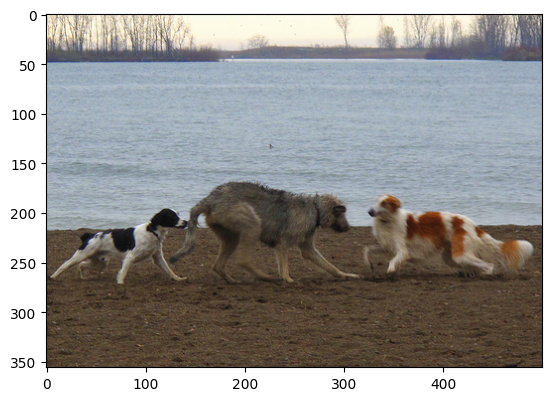

In [ ]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']

img_ids = [7999, 500, 6000, 460,3]

for img_id in img_ids:
  image = img_name_val[img_id]
  print("Image ID:", img_id)
  print(image)

  cap = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]]) #connect caption with image id from validation set
  caption,result,attention_weights = evaluate(image)

  f = cap.split(' ', 1)[1] #split caption to two parts
  cap2 = f.rsplit(' ', 1)[0]

  #remove "<unk>" in result
  for i in caption:
      if i=="<unk>":
          caption.remove(i)

  for i in cap2:
      if i=="<unk>":
          cap.remove(i)

  #remove <end> from result
  result = ' '.join(caption)
  result = result.rsplit(' ', 1)[0]

  gt = []
  gt.append(cap.split())
  reference = gt #list of words from actual ground truth captions
  candidate = caption #predited caption value

  score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
  print(f"BLEU-1 score: {score*100}- {caption}")
  score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
  print(f"BLEU-2 score: {score*100}")
  score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
  print(f"BLEU-3 score: {score*100}")
  score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
  print(f"BLEU-4 score: {score*100}")

  print ('Real Caption:', gt)
  print ('Predicted Caption:', ' '.join(caption))

  image = np.array(Image.open(image))#show image
  plt.imshow(image)


/content/flickr8k/Images/724702877_f2a938766b.jpg
BLEU-1 score: 33.09363384692233
BLEU-2 score: 20.42583425999594
BLEU-3 score: 1.8560791299878595e-91
BLEU-4 score: 6.33313451367699e-153
Real Caption: small dog catches tennis ball in its mouth indoors
Predicted Caption: yellow dog is running to catch tennis ball


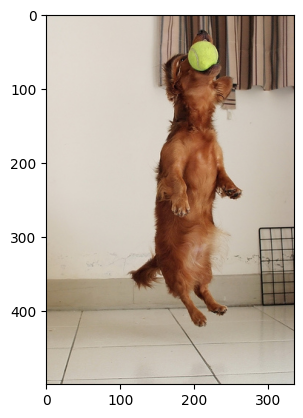

/content/flickr8k/Images/538825260_a4a8784b75.jpg
BLEU-1 score: 45.45454545454545
BLEU-2 score: 21.320071635561046
BLEU-3 score: 2.0020574018996266e-91
BLEU-4 score: 6.887578243315168e-153
Real Caption: woman with green shirt takes drink from water fountain
Predicted Caption: woman in colorful shirt is taking picture from the water fountain


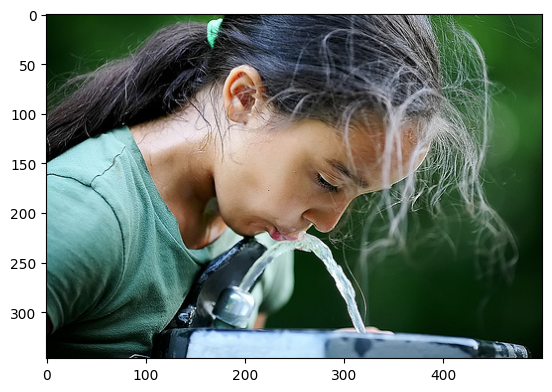

/content/flickr8k/Images/3104400277_1524e4f758.jpg
BLEU-1 score: 25.0
BLEU-2 score: 7.458340731200295e-153
BLEU-3 score: 1.6896185209462902e-183
BLEU-4 score: 1.2882297539194153e-229
Real Caption: dirt bikers on trail
Predicted Caption: two people on motorbikes


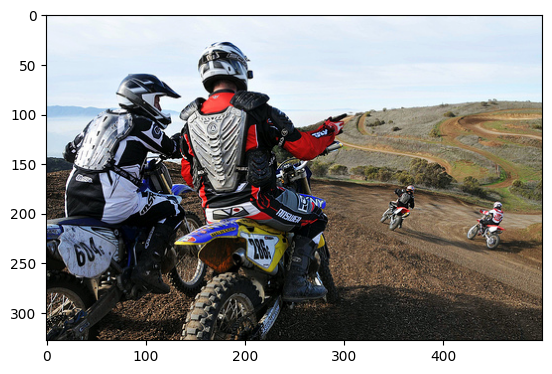